# Sunspots - Time series problem

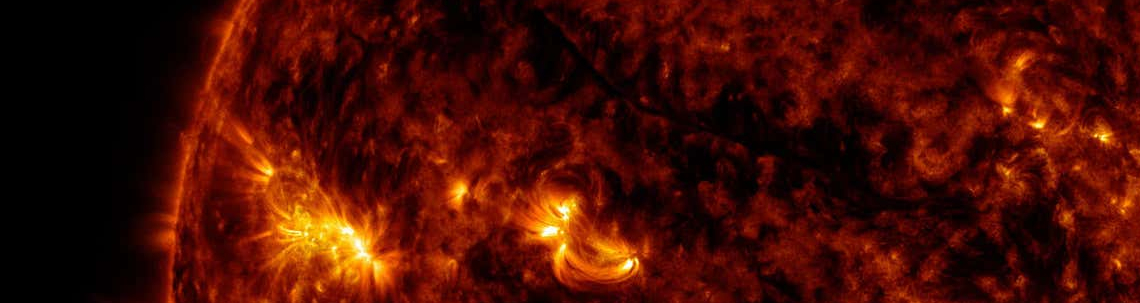

## Outline
- [0. Overview](#0)
- [1. Read and explore dataset](#1)
- [2. Prepare data](#2)
- [3. Train model](#3)
- [4. Predict](#4)
- [5. TO DO](#5)

<a name='0'></a>
# 0. Overview
Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle.
In this notebook, we attempt to model and predict the number of sunspots given historical data dating back to 1749. This is a [Kaggle](https://www.kaggle.com/robervalt/sunspots) dataset.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D, Dropout, Bidirectional, Lambda, Input
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# set random seeds for reproducibility
tf.random.set_seed(51)
np.random.seed(51)

<a name='1'></a>
# 1. Read and explore dataset
Each sample has the following:

*   Index
*   Date
*   Monthly mean total sunspot number

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
            path = os.path.join(dirname, filename)

In [ ]:
df = pd.read_csv(path, names=['index', 'date', 'sunspot'], header=0)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
print(df.head(10))
max_sunspot = df.sunspot.values.max()
print('Max sunspot recorded: ', max_sunspot)

### Visualizing forecasting data

In [ ]:
df.plot('date', 'sunspot', figsize=(15,10))
df.plot('index', 'sunspot', figsize=(15,10))

We can also plot the average per year to average out the month-to-month variance and see the pattern more clearly.

In [ ]:
df.groupby(df.date.dt.year)['sunspot'].mean().plot(figsize=(15,10))

<a name='2'></a>
# 2. Prepare data
Turn pandas dataframe into arrays for training, specifically, splitting features and labels and batching

In [ ]:
scaler = MinMaxScaler().fit(df.sunspot.values.reshape(-1, 1))
sunspot_values = scaler.transform(df.sunspot.values.reshape(-1, 1))

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # create dataset from series
    ds = tf.data.Dataset.from_tensor_slices(series)
    # slice data into appropiate windows
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    # flatten data into batches
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    # shuffle to avoid overfitting
    ds = ds.shuffle(shuffle_buffer)
    # separate features and label
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    # batch for training
    ds = ds.batch(batch_size).prefetch(1)
    return ds

<a name='3'></a>
# 3. Train model
Since we know that the seasonality of this phenomenom is about ~11 years, we can split the data such that the training set takes a multiple of it.

In [ ]:
split_time = 12*11*20 # 12 months * 11 years * 20 cycles
window_size = 50
batch_size = 10

x_train = sunspot_values[:split_time]
train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=len(x_train))
x_val = sunspot_values[split_time:]
val_set = windowed_dataset(x_val, window_size=window_size, batch_size=batch_size, shuffle_buffer=len(x_val))
time_train = df.index.values[:split_time]
time_val = df.index.values[split_time:]
print('Train size: ', len(x_train))
print('Val size: ', len(x_val))

In [ ]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(Input(shape=[None, 1], name='sunspot'))
model.add(Bidirectional(LSTM(50, dropout=0.05, return_sequences=True)))
model.add(Bidirectional(LSTM(50, dropout=0.05, return_sequences=True)))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.summary()

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))
model.compile(Adam(lr=1e-7), loss=tf.keras.losses.Huber(), metrics=["mae"])
train_history = model.fit(train_set,
                epochs=100, 
                batch_size=batch_size, 
                verbose=2, 
                validation_data=val_set,
                callbacks=[lr_schedule])

Plot the learning rate versus the loss to choose the ideal learning rate. According to this [study](https://arxiv.org/abs/1506.01186), we need to choose the learning rate that has the greatest slope. Looking at the image below, we will choose ~9e-6.

In [ ]:
plt.semilogx(train_history.history["lr"], train_history.history["loss"])
plt.semilogx(train_history.history["lr"], train_history.history["val_loss"])
plt.axis([1e-8, 1e-3, 0, 0.034])

In [ ]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(Input(shape=[None, 1], name='sunspot'))
model.add(Bidirectional(LSTM(50, dropout=0.05, return_sequences=True)))
model.add(Bidirectional(LSTM(50, dropout=0.05, return_sequences=True)))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.summary()

model.compile(Adam(lr=9e-6), loss=tf.keras.losses.Huber(), metrics=["mae"])
train_history = model.fit(train_set,
                epochs=500, 
                batch_size=batch_size, 
                verbose=2, 
                validation_data=val_set
                         )

In [ ]:
train_loss = train_history.history['loss'][100:]
val_loss = train_history.history['val_loss'][100:]
epochs = range(len(train_loss))
plt.figure(figsize=(20, 10))
plt.plot(epochs, train_loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Val Loss"])

By plotting the validation loss alone, we can see that there is a constant decrease and indicates that the model is not overfitting. Further fine-tune of hyperparameters is needed to smooth out the noise.

In [ ]:
val_loss = train_history.history['val_loss'][100:]
epochs = range(len(val_loss))
plt.figure(figsize=(20, 10))
plt.plot(epochs, val_loss, 'b')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Val Loss"])

<a name='4'></a>
# 4. Predict
Using our trained model, we can now predict and compare our predictions using the mean absolute error.

In [ ]:
forecast = []
for time in range(len(sunspot_values) - window_size):
    forecast.append(model.predict(sunspot_values[time:time + window_size][np.newaxis]))

In [ ]:
train_preds = np.array(forecast[: split_time - window_size])[:, 0, 0]
train_preds = scaler.inverse_transform(train_preds.reshape(-1,1))
x_train = scaler.inverse_transform(x_train.reshape(-1,1))
plt.figure(figsize=(15, 10))
plt.plot(time_train[window_size:], x_train[window_size:], 'r')
plt.plot(time_train[window_size:], train_preds, 'b')
plt.title('Train predictions')

In [ ]:
print('Train mean absolute error (mae): ')
print(tf.keras.metrics.mean_absolute_error(x_train[window_size:].ravel(), train_preds.ravel()).numpy())

In [ ]:
val_preds = np.array(forecast[split_time:])[:, 0, 0]
val_preds = scaler.inverse_transform(val_preds.reshape(-1,1))
x_val = scaler.inverse_transform(x_val.reshape(-1,1))

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(time_val[:-window_size], x_val[window_size:], 'r')
plt.plot(time_val[:-window_size], val_preds, 'b')
plt.title('Validation predictions')

In [ ]:
print('Validation mean absolute error (mae): ')
print(tf.keras.metrics.mean_absolute_error(x_val[window_size:].ravel(), val_preds.ravel()).numpy())

<a name='5'></a>
# 4. TO DO

The mean absolute error is as high but we can do better (specially near the peaks), the following are to be studied:

- Add recurrent dropout on each LSTM model
- Fine-tune the batch size and window size
- Explore other model architectures (number of LSTM/Dense layers)
- Add convolutional layers